In [1]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [3]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [8]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        # plt.hist(y)
        # plt.show()
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [5]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
device = mps_device

In [7]:
# please change the data_path to your local path
# data_path = '/nfs/home/zihaoz/limit_order_book/data'

dec_data = np.loadtxt('/Users/jandh/Downloads/data (1)/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/Users/jandh/Downloads/data (1)/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [9]:
batch_size = 64

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

(203800, 40)
(50950, 40)
(139587, 40)
torch.Size([203701, 1, 100, 40]) torch.Size([203701])


# F1-10 Dataset

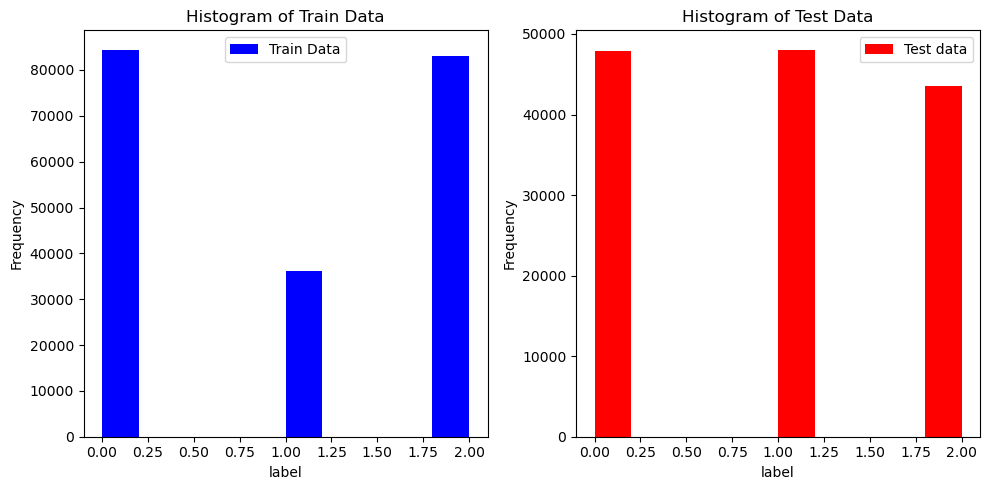

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(dataset_train.y, color='blue', label='Train Data')
axs[0].set_xlabel('label')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Train Data')
axs[0].legend()

# Plot the second histogram
axs[1].hist(dataset_test.y, color='red', label='Test data')
axs[1].set_xlabel('label')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Test Data')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
del [dataset_train,dataset_test,dataset_val]